In [61]:
using Graphs
using Plots
using LinearAlgebra
using Statistics
include("../sis.jl")
include("../mpdbp.jl")
include("../exact/montecarlo.jl")
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

In [192]:
q = q_sis
T = 20
N = 20
k = 3
gg = random_regular_graph(N, k)
g = IndexedGraph(gg)
λ = 0.1
κ = 0.08
p⁰ = map(1:N) do i
    p_infected = 0.15
    [1-p_infected, p_infected]
end
sis = SIS(g, λ, κ, T; p⁰);

In [193]:
# return epidemic instance as an `N`-by-`T`+1 matrix and `MPdBP` object
function simulate_sis(g::IndexedGraph, λ::Real, κ::Real, p⁰::Vector{Vector{F}}, T::Integer, 
        nobs::Integer) where {F<:Real}
    
    sis = SIS(g, λ, κ, T; p⁰)
    bp = mpdbp(sis, d=1)
    X, _ = onesample(bp)
    draw_node_observations!(bp.ϕ, X, nobs, softinf=1e2)
    
    X, bp
end

simulate_sis (generic function with 1 method)

In [194]:
function find_zero_patients_bp(bp::MPdBP;
        svd_trunc = TruncBond(5), tol=1e-3, maxiter=100) where {F<:Real}
    cb = CB_BP(bp)
    iters, ε = iterate!(bp; maxiter, svd_trunc, cb, tol)
    iters == maxiter && error("BP did not converge")
    b = beliefs(bp)
    b⁰ = [bb[1] for bb in b]
    p = sortperm(b⁰, by=x->x[1])
    eachindex(b⁰)[p], [bb[I] for bb in b⁰[p]]
end

find_zero_patients_bp (generic function with 1 method)

In [195]:
function find_zero_patients_mc(bp::MPdBP; nsamples=10^4) where {F<:Real}
    sms = sample(bp, nsamples)
    b = marginals(sms)
    b⁰ = [bb[1] for bb in b]
    p = sortperm(b⁰, by=x->x[1])
    eachindex(b⁰)[p], [bb[I] for bb in b⁰[p]], sms
end

find_zero_patients_mc (generic function with 1 method)

In [196]:
nobs = 50
X, bp = simulate_sis(g, λ, κ, p⁰, T, nobs);

In [197]:
true_zp = findall(isequal(I), X[:,1]) 

3-element Vector{Int64}:
  5
 15
 18

In [198]:
@time begin
    id_bp, b⁰_bp = find_zero_patients_bp(bp)
end
[id_bp b⁰_bp][1:10,:]

Running MPdBP: iter 16 	 Time: 0:00:24
  Δ:  0.0007803215171817146

 24.671888 seconds (62.89 M allocations: 21.971 GiB, 7.45% gc time, 0.90% compilation time)


10×2 Matrix{Float64}:
  5.0  0.775963
 18.0  0.348137
 10.0  0.314363
 15.0  0.2468
 14.0  0.22566
  7.0  0.200599
 12.0  0.163643
  6.0  0.148035
 13.0  0.120249
 16.0  0.0983411

In [199]:
nsamples = 10^5
@time begin
    id_mc, b⁰_mc, sms = find_zero_patients_mc(bp; nsamples)
end
[id_mc [b.val for b in b⁰_mc]][1:10,:]

SoftMargin sampling... 100%|█████████████████████████████| Time: 0:00:20


 21.239018 seconds (229.92 M allocations: 12.046 GiB, 12.81% gc time, 1.10% compilation time)


10×2 Matrix{Float64}:
 18.0  0.655512
  7.0  0.334226
  4.0  0.324339
 16.0  0.321189
 15.0  0.0101542
 12.0  0.0100228
 10.0  0.00678146
 13.0  0.0067507
  5.0  0.00674803
 17.0  0.00343824

SIS on random regular graph N=20, k=3. P(S→I)=0.1, P(I→S)=0.08.


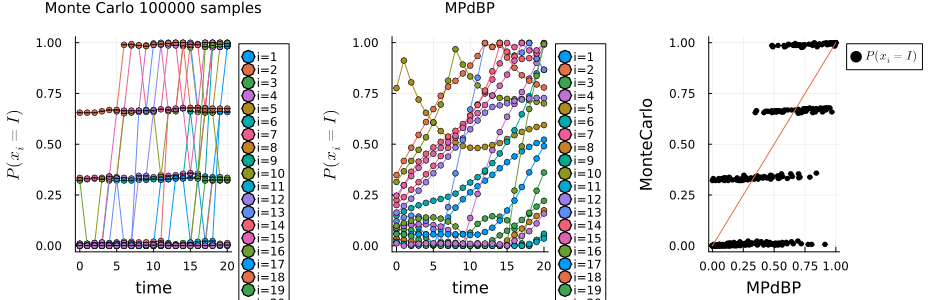

In [200]:
b_bp = beliefs(bp)
p_bp = [[bbb[2] for bbb in bb] for bb in b_bp]
b_mc = marginals(sms)
p_mc = [[bbb[2] for bbb in bb] for bb in b_mc]
pl_mc = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:5:T, title="Monte Carlo $nsamples samples")
for i in 1:N
    plot!(pl_mc, 0:T, p_mc[i], label="i=$i", m=:o, ms=3, lw=1)
end
pl_bp = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:5:T, title="MPdBP")
for i in 1:N
    plot!(pl_bp, 0:T, p_bp[i], label="i=$i", m=:o, ms=3, lw=1)
end
pl_sc = scatter(reduce(vcat, p_bp), reduce(vcat, p_mc), xlabel="MPdBP", ylabel="MonteCarlo", 
    label="\$P(x_i=I)\$", ms=3, c=:black, legend=:outertopright)
plot!(identity, label="", size=(300,300))
println("SIS on random regular graph N=$N, k=$k. P(S→I)=$λ, P(I→S)=$κ.")
# println("$nobs_node random node observations, $nobs_edge random edge observations")
# println("Max matrix size: ", svd_trunc.mprime, "x", svd_trunc.mprime)
plot(pl_mc, pl_bp, pl_sc, titlefontsize=10, size=(950, 300), legend=:outertopright, 
    margin=5Plots.mm, layout=(1,3))

In [201]:
function roc(guess_zp, true_zp)
    r = guess_zp .∈ (true_zp,)
    cumsum(r ./ sum(r))
end

function auc(guess_zp, true_zp)
    r = roc(guess_zp, true_zp)
    mean(r)
end

auc (generic function with 1 method)

In [202]:
auc(id_bp, true_zp), auc(id_mc, true_zp)

(0.9333333333333332, 0.8)